In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data shape: (768, 8)
Target distribution: [500 268]
Using device: cpu
Epoch   1/200  Train Loss: 0.7174  Val Loss: 0.6965
Epoch  20/200  Train Loss: 0.4859  Val Loss: 0.5031
Epoch  40/200  Train Loss: 0.4452  Val Loss: 0.4896
Epoch  60/200  Train Loss: 0.4331  Val Loss: 0.4972
Epoch  80/200  Train Loss: 0.4257  Val Loss: 0.5004
Epoch 100/200  Train Loss: 0.4199  Val Loss: 0.5031
Epoch 120/200  Train Loss: 0.4144  Val Loss: 0.5069
Epoch 140/200  Train Loss: 0.4100  Val Loss: 0.5090
Epoch 160/200  Train Loss: 0.4058  Val Loss: 0.5126
Epoch 180/200  Train Loss: 0.4020  Val Loss: 0.5146
Epoch 200/200  Train Loss: 0.3980  Val Loss: 0.5173


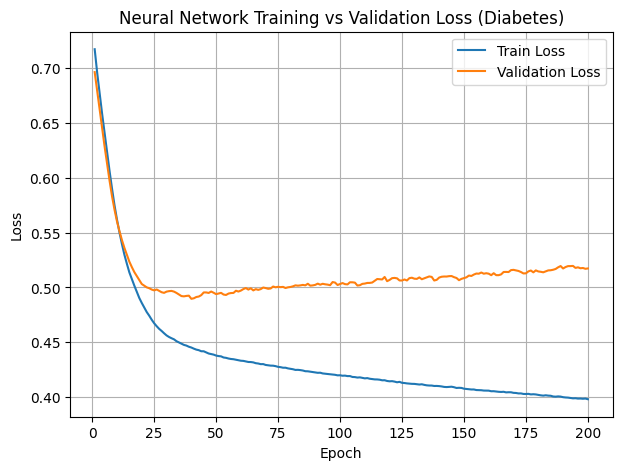


=== Neural Network Performance (Validation set) ===
Accuracy : 0.7273
Precision: 0.6250
Recall   : 0.5556
F1-score : 0.5882

=== Logistic Regression (Validation set) ===
Accuracy : 0.7143
Precision: 0.6087
Recall   : 0.5185
F1-score : 0.5600

=== Support Vector Machine (Validation set) ===
Accuracy : 0.7532
Precision: 0.6600
Recall   : 0.6111
F1-score : 0.6346

=== MODEL COMPARISON (Validation set) ===
Model                   Acc   Prec    Rec     F1
--------------------------------------------------
Neural Net            0.727  0.625  0.556  0.588
Logistic Reg.         0.714  0.609  0.519  0.560
SVM (RBF)             0.753  0.660  0.611  0.635


In [5]:

data_path = '/content/drive/MyDrive/Courses/ML/diabetes.csv'

df = pd.read_csv(data_path)


target_col = 'Outcome'
X = df.drop(columns=[target_col]).values.astype(np.float32)
y = df[target_col].values.astype(np.int64)

print("Data shape:", X.shape)
print("Target distribution:", np.bincount(y))

# TRAIN / VALIDATION SPLIT
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (fit on train only!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32).to(device)

input_dim = X_train.shape[1]

# Fully connected network with fewer hidden layers
class DiabetesNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 12),
            nn.ReLU(),
            nn.Linear(12, 1)
        )


    def forward(self, x):
        return self.net(x)

model = DiabetesNet(input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# TRAINING LOOP
num_epochs = 200
batch_size = 32

train_losses = []
val_losses   = []

def get_batches(X, y, batch_size):
    idx = np.random.permutation(len(X))
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        batch_idx = idx[start:end]
        yield X[batch_idx], y[batch_idx]

for epoch in range(1, num_epochs+1):
    model.train()
    epoch_train_loss = 0.0
    for xb_np, yb_np in get_batches(X_train, y_train, batch_size):
        xb = torch.tensor(xb_np, dtype=torch.float32).to(device)
        yb = torch.tensor(yb_np, dtype=torch.float32).unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * xb.size(0)

    epoch_train_loss /= len(X_train)

    # Validation loss
    model.eval()
    with torch.no_grad():
        logits_val = model(X_val_t)
        y_val_float = y_val_t.unsqueeze(1)
        val_loss = criterion(logits_val, y_val_float).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{num_epochs}  "
              f"Train Loss: {epoch_train_loss:.4f}  Val Loss: {val_loss:.4f}")

# PLOT TRAIN vs VALIDATION LOSS
plt.figure(figsize=(7,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training vs Validation Loss (Diabetes)')
plt.legend()
plt.grid(True)
plt.show()

# EVALUATE NEURAL NETWORK
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
with torch.no_grad():
    logits_val = model(X_val_t)
    probs_val = torch.sigmoid(logits_val).cpu().numpy().ravel()
    y_pred_nn = (probs_val >= 0.5).astype(int)

acc_nn  = accuracy_score(y_val, y_pred_nn)
prec_nn = precision_score(y_val, y_pred_nn, zero_division=0)
rec_nn  = recall_score(y_val, y_pred_nn, zero_division=0)
f1_nn   = f1_score(y_val, y_pred_nn, zero_division=0)

print("\n=== Neural Network Performance (Validation set) ===")
print(f"Accuracy : {acc_nn:.4f}")
print(f"Precision: {prec_nn:.4f}")
print(f"Recall   : {rec_nn:.4f}")
print(f"F1-score : {f1_nn:.4f}")

# LOGISTIC REGRESSION & SVM BASELINES
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

acc_log  = accuracy_score(y_val, y_pred_log)
prec_log = precision_score(y_val, y_pred_log, zero_division=0)
rec_log  = recall_score(y_val, y_pred_log, zero_division=0)
f1_log   = f1_score(y_val, y_pred_log, zero_division=0)

# Support Vector Machine (use RBF kernel by default)
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_val)

acc_svm  = accuracy_score(y_val, y_pred_svm)
prec_svm = precision_score(y_val, y_pred_svm, zero_division=0)
rec_svm  = recall_score(y_val, y_pred_svm, zero_division=0)
f1_svm   = f1_score(y_val, y_pred_svm, zero_division=0)

print("\n=== Logistic Regression (Validation set) ===")
print(f"Accuracy : {acc_log:.4f}")
print(f"Precision: {prec_log:.4f}")
print(f"Recall   : {rec_log:.4f}")
print(f"F1-score : {f1_log:.4f}")

print("\n=== Support Vector Machine (Validation set) ===")
print(f"Accuracy : {acc_svm:.4f}")
print(f"Precision: {prec_svm:.4f}")
print(f"Recall   : {rec_svm:.4f}")
print(f"F1-score : {f1_svm:.4f}")

# SIDE-BY-SIDE COMPARISON
print("\n=== MODEL COMPARISON (Validation set) ===")
print(f"{'Model':<20} {'Acc':>6} {'Prec':>6} {'Rec':>6} {'F1':>6}")
print("-"*50)
print(f"{'Neural Net':<20} {acc_nn:6.3f} {prec_nn:6.3f} {rec_nn:6.3f} {f1_nn:6.3f}")
print(f"{'Logistic Reg.':<20} {acc_log:6.3f} {prec_log:6.3f} {rec_log:6.3f} {f1_log:6.3f}")
print(f"{'SVM (RBF)':<20} {acc_svm:6.3f} {prec_svm:6.3f} {rec_svm:6.3f} {f1_svm:6.3f}")
